# Amazon Fine Food Reviews Analysis

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

    1. Id
    2. ProductId - unique identifier for the product
    3. UserId - unqiue identifier for the user
    4. ProfileName
    5. HelpfulnessNumerator - number of users who found the review helpful
    6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    7. Score - rating between 1 and 5
    8. Time - timestamp for the review
    9. Summary - brief summary of the review
    10.Text - text of the review

Objective:

Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

[Q] How to determine if a review is positive or negative?

[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


# [1] Reading Data

## [1.1] Loading the data

The dataset is available in two forms

    .csv file
    SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [36]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import tqdm
#from tqdm import tqdm
import os

# NB imports
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

#metrics import
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [2]:
con = sqlite3.connect('database.sqlite')

#Normal for every dataset contains a score from 1 to 5. 
#The review must classified as positive or a negative reviews. Neutral reviews such score = 3 are omitted.
#We consider scores 1,2 as negative and 4,5 as positive.So we will consider reviews which are not equal to 3.

filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3 LIMIT 150000", con)
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# For Each review the scores will be 1,2 and 4,5.
# We will mark negative review as 0 and positive reviews as 1 for classification purposes
def partition(x) :
    if x > 3 :
        return 1
    return 0

actualscore = filtered_data['Score']
positivenegative = actualscore.map(partition)
filtered_data['Score'] = positivenegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (150000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
#Checking the database statistics
filtered_data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05
mean,81466.351767,1.683353,2.146233,0.842147,1.296091e+09
std,46958.766654,6.825579,7.418456,0.364605,4.766398e+07
min,1.000000,0.000000,0.000000,0.000000,9.393408e+08
25%,40734.750000,0.000000,0.000000,1.000000,1.270598e+09
50%,81583.500000,0.000000,1.000000,1.000000,1.310947e+09
75%,122047.250000,2.000000,2.000000,1.000000,1.332547e+09
max,162717.000000,559.000000,562.000000,1.000000,1.351210e+09


# 2. Exploratory Data Analysis

## 2.1 Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId='ABXLMWJIXXAIN'
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,320691,B000CQ26E0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",0,0,4,1187740800,"Fast, Easy and organic","For speed and wholesome goodness, Annie's can ..."
1,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
2,468954,B004DMGQKE,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",0,0,5,1351209600,Awesome service and great products,We sent this product as a gift to my husband's...


From the above output we could observe that For a single UserId there are multiple reviews. So we need to sort the data and
delete the duplicate records based on the ProductId and UserId

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, 
                                      kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(126359, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

84.23933333333333

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND HelpfulnessNumerator > HelpfulnessDenominator
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

score = final['Score']

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


(126357, 10)


1    106326
0     20031
Name: Score, dtype: int64

# 3. Preprocessing

## 3.1 Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

    Begin by removing the html tags
    Remove any punctuations or limited set of special characters like , or . or # etc.
    Check if the word is made up of english letters and is not alpha-numeric
    Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
    Convert the word to lowercase
    Remove Stopwords
    Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [12]:
sent_100 = final['Text'].values[100]
print("="*50)
print(sent_100)
print("="*50)

My only complaint about this product is that sometimes it is difficult to squeeze just a very small amount from the bottle into the mixture to be colored.  I don't do massive amounts of baking, and I find that sometimes it is really hard to get a very light color when adding this product to very small quantities of mixture.  However, the colors are very bright and I was very pleased to find that the color is evenly distributed throughout the mixture.  I thought this product was a little pricy, but after trying it out, I do believe that it was worth the extra money.  The product seems of high quality and it shows in my cooking whenever I want to add some color to things.


In [13]:
def cleanhtml(sentence):
    sent = re.sub(r"http\S+", "", sentence)
    return sent

In [14]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def rmwrdswithnumbers(sentence):
    sent = re.sub("\S*\d\S*", "", sentence).strip()
    return sent

In [16]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
def rmspcchar(sentence):
    sent = re.sub('[^A-Za-z0-9]+', ' ', sentence)
    return sent

In [17]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kirankumar_yeddala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
from tqdm import tqdm
preprocessed_reviews = []
for sentance in tqdm(final['Text'].values):
    sentance = cleanhtml(sentance)
    sentance = decontracted(sentance)
    sentance = rmwrdswithnumbers(sentance)
    sentance = rmspcchar(sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 126357/126357 [00:14<00:00, 8779.37it/s]


In [19]:
preprocessed_reviews[100]

'complaint product sometimes difficult squeeze small amount bottle mixture colored massive amounts baking find sometimes really hard get light color adding product small quantities mixture however colors bright pleased find color evenly distributed throughout mixture thought product little pricy trying believe worth extra money product seems high quality shows cooking whenever want add color things'

# 3.2 Preprocessing Review Summary

In [20]:
from tqdm import tqdm
preprocessed_reviews_summary = []
for sentance in tqdm(final['Summary'].values):
    sentance = cleanhtml(sentance)
    sentance = decontracted(sentance)
    sentance = rmwrdswithnumbers(sentance)
    sentance = rmspcchar(sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(sentance.strip())

100%|██████████| 126357/126357 [00:02<00:00, 49708.05it/s]


In [21]:
preprocessed_reviews_summary[100]

'happy'

In [22]:
# Splitting the data into train, cross validate and test (Train = 60%, CV = 20%, Test = 20%)
x_train1, x_test, y_train1, y_test = train_test_split(preprocessed_reviews, score, test_size=0.2, 
                                                    stratify=None, random_state=0)
x_train, x_cv, y_train, y_cv= train_test_split(x_train1, y_train1, test_size = 0.25, random_state = 0,
                                                       stratify = None)

# 4. Featurization

# 4.1 Bag of Words

In [23]:
#*********BOW***************
bow_vect = CountVectorizer()
model = bow_vect.fit(x_train)
bow_train = model.transform(x_train)
bow_cv = model.transform(x_cv)
bow_test = model.transform(x_test)

# 4.2 TFIDF

In [68]:
#*******TFIDF********************
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 10, max_features=5000)
model_tf = tfidf_vect.fit(x_train)
tfidf_train = model_tf.transform(x_train)
tfidf_cv = model_tf.transform(x_cv)
tfidf_test = model_tf.transform(x_test)

# 4.3 W2V

In [26]:
#********W2V*********************
w2v_words = []
for sent in preprocessed_reviews:
    w2v_words.append(sent.split())
w2v = Word2Vec(w2v_words, min_count=5, size=50, workers=4)
w2v_words_list = list(w2v.wv.vocab)

# 4.3.1 AVG W2V

In [27]:
#********AvgW2V******************
avg_w2vs = []
for sent in tqdm(preprocessed_reviews):
    #initializing number of words
    n_words = 0
    #initializing vector of size of 50
    sent_vec = np.zeros(50)
    for word in sent.split():
        if word in w2v_words_list:
            #creating for each word is an vector
            vec = w2v.wv[word]
            sent_vec += vec
            n_words += 1
    if n_words != 0:
        sent_vec /= n_words
        avg_w2vs.append(sent_vec)
print(len(avg_w2vs))
print(len(avg_w2vs[0]))

100%|██████████| 87773/87773 [18:38<00:00, 78.46it/s] 

87773
50


# 4.4 TFIDF W2V

In [28]:
#*********TfidfW2V*******************
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf = tfidf_vect.fit_transform(preprocessed_reviews)
features = tfidf_vect.get_feature_names()
tfidf_w2vs = []
row = 0
for sent in tqdm(preprocessed_reviews):
    sent_vec = np.zeros(50)
    tfidf_sum = 0
    for word in sent.split():
        if(word in w2v_words and word in features):
            vec = w2v.wv[word]
            tfidf_value = tfidf[row, features.index(word)]
            sent_vec += (vec * tfidf_value)
            tfidf_sum += tfidf_value
    if(tfidf_sum != 0):
        sent_vec /= tfidf_sum
        tfidf_w2vs.append(sent_vec)
    row += 1

100%|██████████| 87773/87773 [2:26:44<00:00,  9.97it/s]  


In [25]:
# Here we are trying to find AUC score for each alpha using cross validation data. We are using simple cross
# validation data
def Multi_NB_CV(x_cv, x_test, y_cv, y_test):
    cv_auc = []
    alpha = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]
    for i in alpha:
        tbs = TimeSeriesSplit(n_splits=10)
        nb = MultinomialNB(alpha = i)
        nb.fit(x_cv, y_cv)
        pred_cv = nb.predict_proba(x_cv)[:,1]
        cv_auc.append(roc_auc_score(y_cv,pred_cv))
        print("for alpha = {0} the roc_auc_score is {1}". format(i, roc_auc_score(y_cv,pred_cv)))
    optimal_alpha_cv = alpha[cv_auc.index(max(cv_auc))]
    return cv_auc, optimal_alpha_cv

In [26]:
# Here we are trying to find AUC score for each alpha using Train data. We are using simple cross
#- validation data
def Multi_NB_train(x_train, x_test, y_train, y_test):
    train_auc = []
    alpha = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]
    for i in alpha:
        tbs = TimeSeriesSplit(n_splits=10)
        nb = MultinomialNB(alpha = i)
        nb.fit(x_train, y_train)
        pred_train = nb.predict_proba(x_train)[:,1]
        train_auc.append(roc_auc_score(y_train,pred_train))
        print("for alpha = {0} the roc_auc_score is {1}". format(i, roc_auc_score(y_train,pred_train)))
    optimal_alpha_train = alpha[train_auc.index(max(train_auc))]
    return train_auc, optimal_alpha_train, nb

In [27]:
# Plotting the AUC score 
def ploting_train_cv(alpha, train_auc, cv_auc):
    plt.plot(alpha, cv_auc, label = 'cv_auc')
    plt.plot(alpha, train_auc, label = 'train_auc')
    plt.xlabel('hyperparameter')
    plt.ylabel('area under AUC curve')
    plt.title("Train AUC vs Validate AUC")
    plt.grid()
    plt.legend()
    plt.show()

In [87]:
# Function for ROC Curve 
from sklearn.metrics import roc_curve
def roc_cur(x_train, x_test, y_train, y_test, optimal_alpha):
    model = MultinomialNB(alpha = optimal_alpha)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    pred_score = model.predict_proba(x_test)[:,1]
    print('For alpha {0} the area under AUC curve is = {1}\n'.format(optimal_alpha, roc_auc_score(y_test, pred_score)))
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, pred_score)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title("ROC Curve")
    plt.plot(fpr, tpr, 'b', label = 'AUC %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return pred

In [29]:
# Function for calculating different metrics
def metrics(gsearch_cv, std_test, y_test, x_train, y_train):
    best_estimator = gsearch_cv.best_estimator_
    best_estimator.fit(x_train, y_train)
    y_pred = best_estimator.predict(std_test)
    print("Accuracy on test data:", round(accuracy_score(y_test, y_pred) * 100 , 2))
    print("Precision on test data:", round(precision_score(y_test, y_pred) * 100 , 2))
    print("Recall on test data:", round(recall_score(y_test, y_pred) * 100 , 2))
    print("F1_score on test data:", round(f1_score(y_test, y_pred) * 100,2))
    return y_pred

In [30]:
# Function for printing the confusion matrix
def confus_mat(y_test, pred):
    co_mt = confusion_matrix(y_test,pred)
    class_label = ['negative', 'positive']
    df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
    sns.heatmap(df_conf_matrix, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print('-'*120)
    print("Accuracy on test data:", round(accuracy_score(y_test, pred) * 100 , 2))
    print("Precision on test data:", round(precision_score(y_test, pred) * 100 , 2))
    print("Recall on test data:", round(recall_score(y_test, pred) * 100 , 2))
    print("F1_score on test data:", round(f1_score(y_test, pred) * 100,2))

# 5. Applying Naive Bayes

## 5.1 Applying Multinomial NB on Bow

In [31]:
# Normalizing the data
from sklearn import preprocessing
bow_train = preprocessing.normalize(bow_train)
bow_cv = preprocessing.normalize(bow_cv)
bow_test = preprocessing.normalize(bow_test)

In [56]:
# Calling and Fitting the model
train_auc, optimal_alpha_train, nb = Multi_NB_train(bow_train, bow_test, y_train, y_test)
optimal_alpha_train

for alpha = 10000 the roc_auc_score is 0.5890951916597568
for alpha = 1000 the roc_auc_score is 0.6258857430229732
for alpha = 100 the roc_auc_score is 0.6800231466949458
for alpha = 10 the roc_auc_score is 0.762482471412153
for alpha = 1 the roc_auc_score is 0.9233197889736758
for alpha = 0.1 the roc_auc_score is 0.9616149385850794
for alpha = 0.01 the roc_auc_score is 0.9733195484446174
for alpha = 0.001 the roc_auc_score is 0.978180940394706
for alpha = 0.0001 the roc_auc_score is 0.9803465931079426


0.0001

In [57]:
cv_auc, optimal_alpha_cv = Multi_NB_CV(bow_cv, bow_test, y_cv, y_test)
optimal_alpha_cv

for alpha = 10000 the roc_auc_score is 0.5836209590465546
for alpha = 1000 the roc_auc_score is 0.6038125736443832
for alpha = 100 the roc_auc_score is 0.6559896115113838
for alpha = 10 the roc_auc_score is 0.7204371858799408
for alpha = 1 the roc_auc_score is 0.8756584368423358
for alpha = 0.1 the roc_auc_score is 0.9735923051605249
for alpha = 0.01 the roc_auc_score is 0.9850165294659033
for alpha = 0.001 the roc_auc_score is 0.9885926697815247
for alpha = 0.0001 the roc_auc_score is 0.9899787655308941


0.0001

## Observation 

### From the above we can see that as the alpha value decreases AUC score increase which means the it is simple model. For alpha = 0.0001 AUC score is higher then we will consider it optimal alpha. 

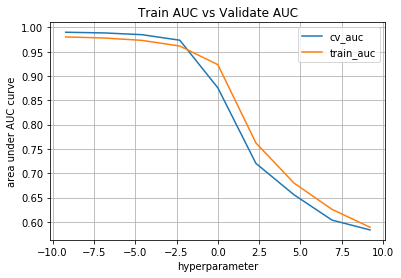

In [58]:
# Plotting on Train AUC and Validate AUC
alpha = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]
alpha = np.log(np.array(alpha))
ploting_train_cv(alpha, train_auc, cv_auc)

### From the above graphy we can see that both train AUC curve and Validate AUC curve decreases with the increase in alpha sharply which means as alpha increases the model becomes dumb model

For alpha 0.0001 the area under AUC curve is = 0.8942846023804469



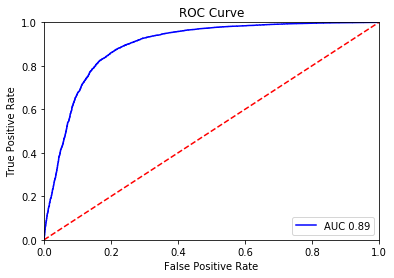

In [89]:
# ROC Curve
pred = roc_cur(bow_train, bow_test, y_train, y_test, optimal_alpha_cv)

### From the above we can area under AUC Curve is above the diagnol line then we can say that my model is better than simple linear model

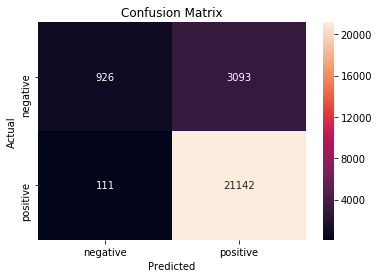

------------------------------------------------------------------------------------------------------------------------
Accuracy on test data: 87.32
Precision on test data: 87.24
Recall on test data: 99.48
F1_score on test data: 92.96


In [90]:
# Confusion Matrix
confus_mat(y_test, pred)

In [61]:
#Top positive and Negative features 
features = bow_vect.get_feature_names()
class_labels = nb.classes_
top_negative = sorted(zip(nb.feature_log_prob_[0], features),reverse=True)[0:10]
top_positive = sorted(zip(nb.feature_log_prob_[1], features),reverse=True)[0:10]
print("Top 10 negative important features")
print("-----------------------------------------")
for coef, feat in top_negative:
    print(feat)
print("-----------------------------------------")
print("Top 10 positive important features")
print("-----------------------------------------")
for coef, feat in top_positive:
    print(feat) 

Top 10 negative important features
-----------------------------------------
br
like
taste
product
would
one
coffee
good
flavor
buy
-----------------------------------------
Top 10 positive important features
-----------------------------------------
br
great
good
like
love
coffee
one
taste
product
flavor


## 5.2 Tfidf on Multinomial NB

In [69]:
# Data Normalisation 
tfidf_train = preprocessing.normalize(tfidf_train)
tfidf_cv = preprocessing.normalize(tfidf_cv)
tfidf_test = preprocessing.normalize(tfidf_test)

In [70]:
# Calling and fitting the model
train_auc, optimal_alpha_train, nb = Multi_NB_train(tfidf_train, tfidf_test, y_train, y_test)
optimal_alpha_train

for alpha = 10000 the roc_auc_score is 0.6296712542528822
for alpha = 1000 the roc_auc_score is 0.6656828421839014
for alpha = 100 the roc_auc_score is 0.7903058848603677
for alpha = 10 the roc_auc_score is 0.9297995331893694
for alpha = 1 the roc_auc_score is 0.9483477156013098
for alpha = 0.1 the roc_auc_score is 0.9499045157218561
for alpha = 0.01 the roc_auc_score is 0.9500742431282064
for alpha = 0.001 the roc_auc_score is 0.950111611502867
for alpha = 0.0001 the roc_auc_score is 0.9501260458636621


0.0001

In [71]:
cv_auc, optimal_alpha_cv = Multi_NB_CV(tfidf_cv, tfidf_test, y_cv, y_test)
optimal_alpha_cv

for alpha = 10000 the roc_auc_score is 0.6281573956131556
for alpha = 1000 the roc_auc_score is 0.6445344302481425
for alpha = 100 the roc_auc_score is 0.7204118214473976
for alpha = 10 the roc_auc_score is 0.897906586115505
for alpha = 1 the roc_auc_score is 0.9574695673122581
for alpha = 0.1 the roc_auc_score is 0.9642367676219629
for alpha = 0.01 the roc_auc_score is 0.9653462314366171
for alpha = 0.001 the roc_auc_score is 0.9657289931903663
for alpha = 0.0001 the roc_auc_score is 0.965919616746104


0.0001

### From the above we can see that for alpha > 10 my auc score is constant for decrease in aplha value. For the  best alpha value is 0.1 So we will consider alpha = 0.1 as our model. 

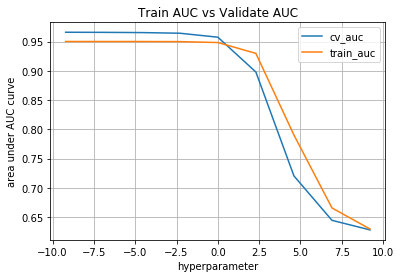

In [72]:
# Plotting Train AUC and Validate AUC
alpha = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]
alpha = np.log(np.array(alpha))
ploting_train_cv(alpha, train_auc, cv_auc)

For alpha 0.0001 the area under AUC curve is = 0.9354631865738856



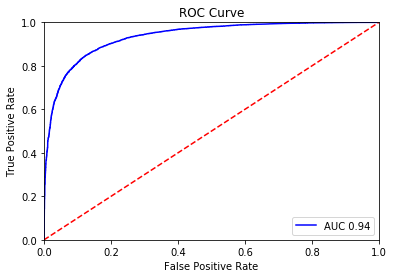

In [86]:
# ROC curve on Train and Test Data
pred = roc_cur(tfidf_train, tfidf_test, y_train, y_test, optimal_alpha_cv)

### From the above we can area under AUC Curve is above the diagnol line then we can say that my model is better than simple linear model

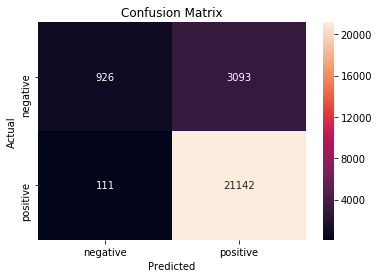

------------------------------------------------------------------------------------------------------------------------
Accuracy on test data: 87.32
Precision on test data: 87.24
Recall on test data: 99.48
F1_score on test data: 92.96


In [91]:
# Confusion Matrix
confus_mat(y_test, pred)

In [75]:
#Top positive and Negative features 
features = tfidf_vect.get_feature_names()
class_labels = nb.classes_
top_negative = sorted(zip(nb.feature_log_prob_[0], features),reverse=True)[0:10]
top_positive = sorted(zip(nb.feature_log_prob_[1], features),reverse=True)[0:10]
print("Top 10 negative important features")
for coef, feat in top_negative:
    print(feat)
print("-----------------------------------------")
print("Top 10 positive important features")
for coef, feat in top_positive:
    print(feat) 

Top 10 negative important features
br
like
product
taste
would
coffee
br br
one
flavor
buy
-----------------------------------------
Top 10 positive important features
br
great
good
coffee
like
love
tea
br br
product
one


# 6. Conclusion 

In [92]:
list_1 = [['BOW',0.0001, 89.42, 87.32, 87.24, 99.48, 92.96],
         ['TFIDF',0.0001, 93.54, 87.54, 88.43, 99.39, 93.59]]
columns= ['Vectorizer', 'Best alpha', 'ROC_AUC', 'Accuracy', 'Precision', 'Recall', 'F1_score']
pd.DataFrame(list_1,columns = columns)

,Vectorizer,Best alpha,ROC_AUC,Accuracy,Precision,Recall,F1_score
0,BOW,0.0001,89.42,87.32,87.24,99.48,92.96
1,TFIDF,0.0001,93.54,87.54,88.43,99.39,93.59
